# Blahut-Arimoto algorithm to compute the channel capacity for a given input-output response.

(c) 2020 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [32]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy

import itertools
# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Pickle is useful for saving outputs that are computationally expensive
# to obtain every time
import pickle

import os
import glob
import git

# Import the project utils
import ccutils

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'retina'

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

figdir = f'{homedir}/fig/blahut_algorithm_channel_capacity/'
tmpdir = f'{homedir}/tmp/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

## Input probability that maximizes the information transmited through a channel $P(m \mid C)$

Given the symmetry in the mutual information, i.e. $I(p;c)=I(c;p)$ the problem of transmiting a message can be studied from two perspectives:
1. Given a **fix input** $P(c)$ what is the input-output response $P(p \mid c)$ that would minimize the information subject to some average distortion $D$. In other words, given that we set a maximum error rate $D$ in the communication channel, what is the minimum amount of information that needs to be transmited to achieve such goal.
2. Given a **fix channel** $P(p \mid c)$ what is the input distribution that would maximize the mutual information.

The first view is treated by rate-distortion theory. The second point is the problem of computing the so-called information capacity of a channel. This channel capacity is defined as

$$
    C \equiv \sup_{P(c)} I,
\tag{1}
$$
where the maximum is taken over the space of probabilities $P(c)$. This means that a probability distribution $P^*(c)$ achieves capacity if it maximizes the information that can be transmitted through a fix channel.

In this script we will implement the Blahut-Arimoto algorithm that numerically searches through the space of all (discrete) input distributions $P(c)$, converging to the input distribution that achieves channel capacity.

## Testing the implementation of the algorithm.

Before going all in with the implementation of the algorithm is worth testing it with a simple example. Let's first implement the algorithm.

In [3]:
def channel_capacity(QmC, epsilon=1e-3, info=1e4):
    """
    Performs the Blahut-Arimoto algorithm to compute the channel capacity
    given a channel QmC.

    Parameters
    ----------
    QmC : array-like 
        definition of the channel with C inputs and m outputs.
    epsilon : float.
        error tolerance for the algorithm to stop the iterations. The smaller
        epsilon is the more precise the rate-distortion function is, but also
        the larger the number of iterations the algorithm must perform
    info : int.
        Number indicating every how many cycles to print the cycle number as
        a visual output of the algorithm.
    Returns
    -------
    C : float.
        channel capacity, or the maximum information it can be transmitted 
        given the input-output function.
    pc : array-like.
        array containing the discrete probability distribution for the input 
        that maximizes the channel capacity
    """
    # initialize the probability for the input.
    pC = np.repeat(1 / QmC.shape[0], QmC.shape[0])

    # Initialize variable that will serve as termination criteria
    Iu_Il = 1

    loop_count = 0
    # Perform a while loop until the stopping criteria is reached
    while Iu_Il > epsilon:
        if (loop_count % info == 0) & (loop_count != 0):
            print("loop : {0:d}, Iu - Il : {1:f}".format(loop_count, Iu_Il))
        loop_count += 1
        # compute the relevant quantities. check the notes on the algorithm
        # for the interpretation of these quantities
        # cC = exp(∑_m Qm|C log(Qm|C / ∑_c pC Qm|C))
        sum_C_pC_QmC = np.sum((pC * QmC.T).T, axis=0)
        QmC_log_QmC_sum_C_pC_QmC = QmC * np.log(QmC / sum_C_pC_QmC)
        # check for values that go to -inf because of 0xlog0
        QmC_log_QmC_sum_C_pC_QmC[np.isnan(QmC_log_QmC_sum_C_pC_QmC)] = 0
        QmC_log_QmC_sum_C_pC_QmC[np.isneginf(QmC_log_QmC_sum_C_pC_QmC)] = 0
        cC = np.exp(np.sum(QmC_log_QmC_sum_C_pC_QmC, axis=1))

        # I_L log(∑_C pC cC)
        Il = np.log(np.sum(pC * cC))

        # I_U = log(max_C cC)
        Iu = np.log(cC.max())

        # pC = pC * cC / ∑_C pC * cC
        pC = pC * cC / np.sum(pC * cC)

        Iu_Il = Iu - Il

    # convert from nats to bits
    Il = Il / np.log(2)
    return Il, pC, loop_count

Now the channel that Arimoto proposes in his paper

In [4]:
QmC = np.array([[0.6, 0.7, 0.5], [0.3, 0.1, 0.05], [0.1, 0.2, 0.45]])

Il, pC, loop_count = channel_capacity(QmC.T, 1e-10)

print("Mutual info:", Il)
print("Input distribution:", pC)
print("Iterations:", loop_count)

Mutual info: 0.16163186082364497
Input distribution: [5.01735450e-01 1.41574430e-09 4.98264548e-01]
Iterations: 305


The algorithm converges to the value reported on the paper. So we know that this implementation is working.


## Computing the channel capacity for a multi-promoter model

Given that the mRNA and protein distributions $P(m, p \mid c)$ were computed using the maximum entropy approximation we can take the Lagrange multipliers associated with each inducer concentration $C$ and build the input output matrix $\mathbf{Q}_{g|c}$, where $g \in \{m, p\}$.

We will take the distribution inferences made with multiple promoters integrating over the entire cell cycle. 

Let's read the resulting Lagrange multipliers and compute the channel capacity for this case. These Lagrange multipliers were fit independently for the mRNA and the protein distribution. So we will read two independent files.

In [5]:
df_maxEnt_mRNA = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/MaxEnt_Lagrange_mult_mRNA.csv"
)

df_maxEnt_prot = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/MaxEnt_Lagrange_mult_protein.csv"
)

Let's now define a function that takes a data frame for a particular repressor copy number and operator with all inducer concentrations, and computes each corresponding distribution $P(m, p \mid c)$ to then marginalize to obtain either $P(m \mid c) = \sum_p P(m, p \mid c)$, or $P(p \mid c) = \sum_m P(m, p \mid c)$. Then it stacks all these marginal distributions to build the input-output matrix $\mathbf{Q}_{g|c}$. In other words, given a list of the Lagrange multipliers and a corresponding set of values of mRNA and protein counts this function builds the joint distribution $P(m, p \mid c)$ and then (if necessary) marginalizes over one of the axis ($\sum_m$ or $\sum_p$).

In [6]:
def trans_matrix(df_lagrange, mRNA_space, protein_space, m_dist=True):
    """
    Function that builds the transition matrix Qg|c for a series of
    concentrations c. It builds the matrix by using the tidy data-frames
    containing the list of Lagrange multipliers.
    
    Parameters
    ----------
    df_lagrange : pandas DataFrame.
        Data Frame containing the lagrange multipliers for a single straing,
        i.e. single operator and repressor copy number value.
    mRNA_space, protein_space : array-like.
        Array containing the sample space for the mRNA and the protein
        respectively
    m_dist : Bool. Default = True.
        Boolean indicating if the mRNA input-output matrix should be 
        returned. If false the protein matrix is returned.
    
    Returns
    -------
    Qg|c : input output matrix in which each row represents a concentration
    and each column represents the probability of mRNA or protein copy 
    number.
    """
    # Extract unique concentrations
    c_array = df_lagrange["inducer_uM"].unique()

    # Extract the list of Lagrange multipliers
    lagrange_mult = [col for col in df_lagrange.columns if "lambda" in col]
    # Extract the exponents corresponding to each Lagrange multiplier
    exponents = []
    for s in lagrange_mult:
        exponents.append([int(n) for n in list(s) if n.isdigit()])

    # Initialize input-output matrix
    if m_dist:
        Qgc = np.zeros([len(mRNA_space), len(c_array)])
    else:
        Qgc = np.zeros([len(protein_space), len(c_array)])

    # Group data frame by inducer concentration
    df_group = df_lagrange.groupby("inducer_uM")

    # Loop through each of the concentrations computing the distribution
    for i, (group, data) in enumerate(df_group):
        # Extract the Lagrange multiplier columns
        lagrange = data.loc[:, lagrange_mult].values[0]

        # Compute the distribution
        Pmp = ccutils.maxent.maxEnt_from_lagrange(
            mRNA_space, protein_space, lagrange, exponents=exponents
        )

        # Marginalize and add marignal distribution to Qg|c
        if m_dist:
            Qgc[:, i] = Pmp.sum(axis=0)
        else:
            Qgc[:, i] = Pmp.sum(axis=1)

    return Qgc

Having defined the function let's test it. We will grab a specific strain with the O2 operator and 260 repressors per cell, build its input-output protein matrix $P(p \mid c) = \sum_m P(m, p \mid c)$, and then compute the channel capacity.

In [7]:
# Extract sample data frame
df_lagrange = df_maxEnt_prot[(df_maxEnt_prot.operator == 'O2') &
                        (df_maxEnt_prot.repressor == 260)]

# Define sample space
mRNA_space = np.arange(0, 50)
protein_space = np.arange(0, 3E4)

# Build input-output matrix Qg|c
QgC = trans_matrix(df_lagrange, mRNA_space, protein_space, False)

Il, pC, loop_count = channel_capacity(QgC.T, 1E-3)

print('channel capacity: {:.2f} bits'.format(Il))

/Users/razo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
/Users/razo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply


channel capacity: 1.95 bits


This is a reasonable value, a little above 1 bit.

Having defined this function let's compute the channel capacity first at the mRNA level.

### mRNA level channel capacity

We systematically computed the channel capacity for the mRNA distributions using this algorithm. These computations are done on the `channcap_mRNA_multi_prom.py` in the scripts folder.

In [8]:
df_cc_mRNA = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/chann_cap_multi_prom_mRNA.csv"
)

df_cc_mRNA.head()

,operator,binding_enery,repressor,channcap
0,O1,-15.3,0.0,0.000000
1,O1,-15.3,1.0,0.213437
2,O1,-15.3,2.0,0.352301
3,O1,-15.3,3.0,0.438570
4,O1,-15.3,4.0,0.498143


### Protein level channel capacity

The same is true for the protein distributions. For this particular case the calculations are done in the script `channcap_protein_multi_prom.py`.

In [9]:
df_cc_protein = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/chann_cap_multi_prom_protein.csv"
)

# Drop infinities
df_cc_protein = df_cc_protein[df_cc_protein.channcap != np.inf]
df_cc_protein.head()

,operator,binding_energy,repressor,channcap,pc
0,O1,-15.3,0.0,0.000000,[0.08333333 0.08333333 0.08333333 0.08333333 0...
1,O1,-15.3,1.0,0.809304,[5.12629933e-01 5.29297818e-04 1.07816047e-64 ...
2,O1,-15.3,2.0,1.054769,[3.95418426e-01 1.12532658e-03 1.02793958e-01 ...
3,O1,-15.3,3.0,1.207747,[3.57401670e-01 3.01902729e-03 9.43404426e-02 ...
4,O1,-15.3,4.0,1.305730,[3.34178087e-01 4.27123332e-03 9.07024965e-02 ...


Now let's take a look again at the channel capacity inferred values both at the mRNA level and at the protein level.

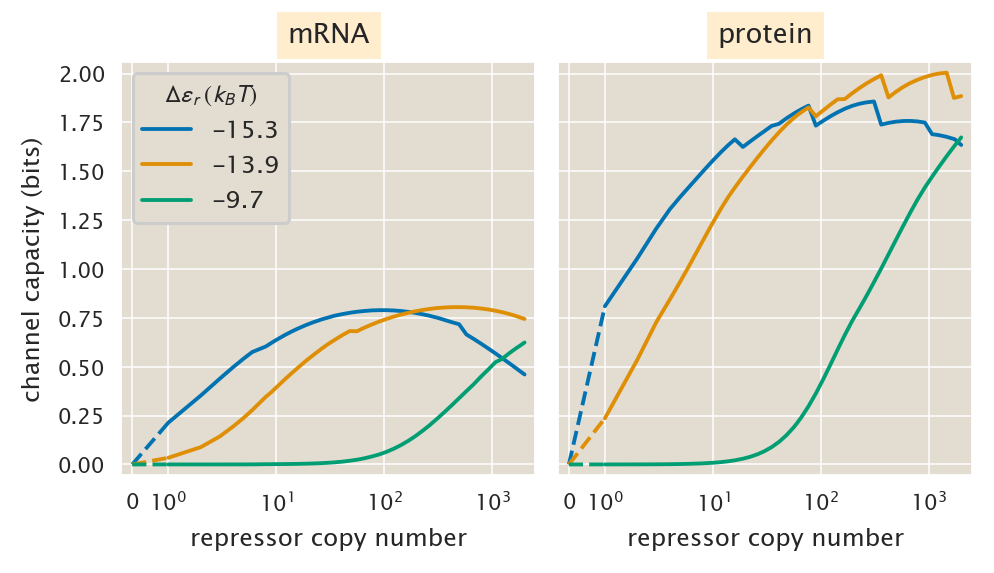

In [10]:
# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5), sharey=True, sharex=True)

# Generate list of colors for each operator
col_list = sns.color_palette("colorblind", n_colors=3)
col_dict = dict(zip(["O1", "O2", "O3"], col_list))
op_dict = dict(zip(df_cc_protein.operator.unique(),
                   df_cc_protein.binding_energy.unique()))

# Group data by operator
df_group = df_cc_mRNA.groupby("operator")

# Define threshold to split linear from logarithmic scale
thresh = 1e0

# Loop through each of the operators
for group, data in df_group:
    # Plot mRNA channel capacity
    # Log scale
    ax[0].plot(
        data[data.repressor >= thresh].repressor,
        data[data.repressor >= thresh].channcap,
        label=op_dict[group],
        color=col_dict[group],
    )

    # Linear scale
    ax[0].plot(
        data[data.repressor <= thresh].repressor,
        data[data.repressor <= thresh].channcap,
        label="",
        color=col_dict[group],
        linestyle="--",
    )

# Group data by operator
df_group = df_cc_protein.groupby("operator")

# Loop through each of the operators
for group, data in df_group:
    # Plot protein channel capacity
    # Log scale
    ax[1].plot(
        data[data.repressor >= thresh].repressor,
        data[data.repressor >= thresh].channcap,
        label=group,
        color=col_dict[group],
    )

    # Linear scale
    ax[1].plot(
        data[data.repressor <= thresh].repressor,
        data[data.repressor <= thresh].channcap,
        label="",
        color=col_dict[group],
        linestyle="--",
    )

# Label plot
ax[0].set_xlabel("repressor copy number")
ax[1].set_xlabel("repressor copy number")
ax[0].set_ylabel("channel capacity (bits)")

# Set title
ax[0].set_title("mRNA", bbox=dict(facecolor="#ffedce"))
ax[1].set_title("protein", bbox=dict(facecolor="#ffedce"))


ax[0].set_xscale("symlog", linthreshx=thresh, linscalex=0.3)
ax[0].margins(0.03)
ax[0].legend(loc="upper left", title=r"$\Delta\epsilon_r \; (k_BT)$")

plt.subplots_adjust(wspace=0.05)
plt.savefig(
    f"{figdir}channel_capacity_mRNA_protein_vs_rep_multipromoter.pdf",
    bbox_inches="tight",
)

Yuk... these curves don't look smooth as before. But the trend is clearly there. Let's get rid of this.

### Smoothing data

Given some numerical instability the curves have some jaggedness to them. In order to remove this we will smooth the curves using the Nadayara-Watson estimator with a Gaussian Kernel as explained in [this excellent tutorial](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2014/tutorials/t5b_data_smoothing.html).

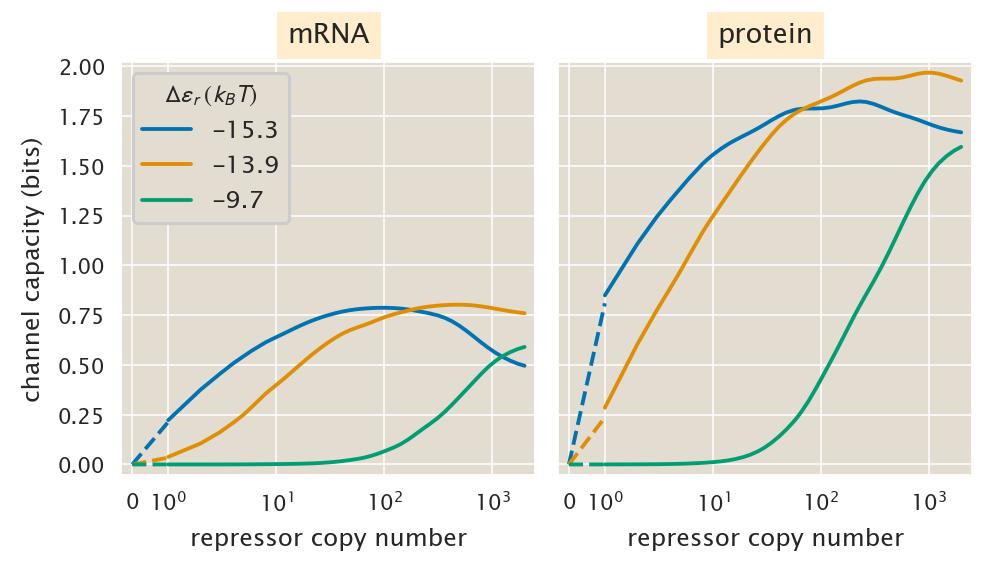

In [11]:
# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5), sharey=True, sharex=True)

# Generate list of colors for each operator
col_list = sns.color_palette("colorblind", n_colors=3)
col_dict = dict(zip(["O1", "O2", "O3"], col_list))

# Group data by operator
df_group = df_cc_mRNA.groupby("operator")

# Define threshold to split linear from logarithmic scale
thresh = 1e0

# Loop through each of the operators
for group, data in df_group:
    # Select x and y data for smoothing
    x = np.log10(data[data.repressor >= thresh].repressor.values)
    y = data[data.repressor >= thresh].channcap.values
    # Define lambda parameter for smoothing
    lam = 0.13
    # Smooth the channel capacity
    channcap_gauss = ccutils.stats.nw_kernel_smooth(x, x, y, lam)
    # Plot mRNA channel capacity
    # Log scale
    ax[0].plot(
        data[data.repressor >= thresh].repressor,
        channcap_gauss,
        label=op_dict[group],
        color=col_dict[group],
    )

    # Linear scale
    ax[0].plot(
        data[data.repressor <= thresh].repressor,
        data[data.repressor <= thresh].channcap,
        label="",
        color=col_dict[group],
        linestyle="--",
    )

# Group data by operator
df_group = df_cc_protein.groupby("operator")

# Loop through each of the operators
for group, data in df_group:
    # Select x and y data for smoothing
    x = np.log10(data[data.repressor >= thresh].repressor.values)
    y = data[data.repressor >= thresh].channcap.values
    # Define lambda parameter for smoothing
    lam = 0.16
    # Smooth the channel capacity
    channcap_gauss = ccutils.stats.nw_kernel_smooth(x, x, y, lam)
    # Plot protein channel capacity
    # Log scale
    ax[1].plot(
        data[data.repressor >= thresh].repressor,
        channcap_gauss,
        label=op_dict[group],
        color=col_dict[group],
    )

    # Linear scale
    ax[1].plot(
        data[data.repressor <= thresh].repressor,
        data[data.repressor <= thresh].channcap,
        label="",
        color=col_dict[group],
        linestyle="--",
    )

# Label plot
ax[0].set_xlabel("repressor copy number")
ax[1].set_xlabel("repressor copy number")
ax[0].set_ylabel("channel capacity (bits)")

# Set title
ax[0].set_title("mRNA", bbox=dict(facecolor="#ffedce"))
ax[1].set_title("protein", bbox=dict(facecolor="#ffedce"))


ax[0].set_xscale("symlog", linthreshx=thresh, linscalex=0.3)
ax[0].margins(0.03)
ax[0].legend(loc="upper left", title=r"$\Delta\epsilon_r \; (k_BT)$")

plt.subplots_adjust(wspace=0.05)
plt.savefig(
    f"{figdir}channel_capacity_mRNA_protein_vs_rep_multipromoter_smooth.pdf",
    bbox_inches="tight",
)

There are two very interesting features in these plots:
First the mRNA channel capacity is systematically smaller than the protein channel capacity. This could initially sound like a violation of the data processing inequality, which states that for a Markov chain of the form

$$
c \rightarrow m \rightarrow p,
\tag{2}
$$
it must be true that

$$
I(c; m) \geq I(c; p).
\tag{3}
$$
Meaning that at each step of the information transmition information can only be lost. So how come the mRNA can carry less information than the protein? The key to solve this apparent paradox is to recall that the data processing inequality talks about instantaneous uses of the communication channel. But here the initial signal $c$ remained constant until reaching steady state, so the protein was able to average out all the high frequency fluctuations of the mRNA, and carry more information about the input. If we were looking at dynamics where we would like to know the instantaneous value of the rapidly changing input $c$, then it would be true that the mRNA would carry more information than the protein. But under the constant input $c$ conditions that the inferences were made this inequality does not apply.

## Compare with experimental data. 

Let's compare these predictions with experimental mircorscopy data at the protein level. First let's read the experimental channel capacity estimations.

In [12]:
# Define directory where data is stored
expdir = f"{homedir}/data/csv_channcap_bootstrap/"

# Define directory where the bootstrap data was stored
bootsdir = f"{homedir}/src/channcap_exp/"

# List files of data taken exclusively for this experiment
bootsfiles = [
    x
    for x in os.listdir(bootsdir)
    if ("channel_capacity_experiment" in x) & ("ipynb" not in x)
]

# Extract dates for these experiments
project_dates = [x.split("_")[0] for x in bootsfiles]


# List files with the bootstrap sampling of the
files = glob.glob(f"{expdir}*channcap_bootstrap.csv")

# Extract dates from these files
file_dates = [file.split("/")[-1] for file in files]
file_dates = [file.split("_")[0] for file in file_dates]

##  Remove data sets that are ignored because of problems with the data quality
##  NOTE: These data sets are kept in the repository for transparency, but they
##  failed at one of our quality criteria
## (see README.txt file in microscopy folder)
ignore_files = [
    x
    for x in os.listdir(f"{homedir}/src/image_analysis/ignore_datasets/")
    if "microscopy" in x
]
# Extract data from these files
ignore_dates = [x.split("_")[0] for x in ignore_files]

# Filter for files taken exclusively for this experiment.
files = [
    file
    for i, file in enumerate(files)
    if (file_dates[i] in project_dates) & (not file_dates[i] in ignore_dates)
]

Let's systematically read each of the files, extract the data from the bin number closest to **100** and compute the channel capacity estimate for this bin number.

But first let's define a couple of dictionaries to map from RBS name to repressor co py number and from operator to binding energy.

In [13]:
# Define dictionaries to map operator to binding energy and rbs to rep copy
op_dict = dict(zip(["O1", "O2", "O3", "Oid"], [-15.3, -13.9, -9.7, -17]))
rbs_dict = dict(
    zip(
        ["HG104", "RBS1147", "RBS446", "RBS1027", "RBS1", "RBS1L"],
        [22, 60, 124, 260, 1220, 1740],
    )
)

Now let's save the data in a tidy `DataFrame`.

In [14]:
# Define index of entries to save
index = [
    "date",
    "bins",
    "operator",
    "rbs",
    "binding energy",
    "repressors",
    "channcap",
]
# Initialize DataFrame to save information
df_cc_exp = pd.DataFrame(columns=index)

# Define bin number to extract
bin_target = 100

# Loop through files
for f in files:
    # Split file name to extract info
    str_split = f.replace(expdir, "").split("_")
    # Extract date, operator and rbs info
    date, op, rbs = str_split[0:3]
    # Map the binding energy and repressor copy number
    eRA, rep = op_dict[op], rbs_dict[rbs]

    # Read file
    df_cc_bs = pd.read_csv(f, header=0)

    # Select df_cc_bs closest to desired number of bins
    # Find the index of the min df_cc_bs
    bin_idx = (np.abs(df_cc_bs["bins"] - bin_target)).idxmin()
    # Choose the bind number
    bin_num = df_cc_bs.iloc[bin_idx]["bins"]

    # Keep only df_cc_bs with this bin number
    df_cc_bs = df_cc_bs[df_cc_bs["bins"] == bin_num]

    # Extrapolate to N -> oo
    x = 1 / df_cc_bs.samp_size
    y = df_cc_bs.channcap_bs
    # Perform linear regression
    lin_reg = np.polyfit(x, y, deg=1)
    # Extract intercept to find channel capacity estimate
    cc = lin_reg[1]

    # Compile info into a pandas series to append it to the DataFrame
    series = pd.Series([date, bin_num, op, rbs, eRA, rep, cc], index=index)
    # Append to DataFrame
    df_cc_exp = df_cc_exp.append(series, ignore_index=True)

df_cc_exp.head()

,date,bins,operator,rbs,binding energy,repressors,channcap
0,20181003,104.0,O2,RBS1027,-13.9,260,1.441127
1,20181009,104.0,O1,HG104,-15.3,22,1.260100
2,20181025,104.0,O2,HG104,-13.9,22,0.794446
3,20181016,104.0,O1,RBS1027,-15.3,260,1.292491
4,20180411,104.0,O1,HG104,-15.3,22,1.234420


Now we are ready to compare our theoretical predictions with the experimental data.

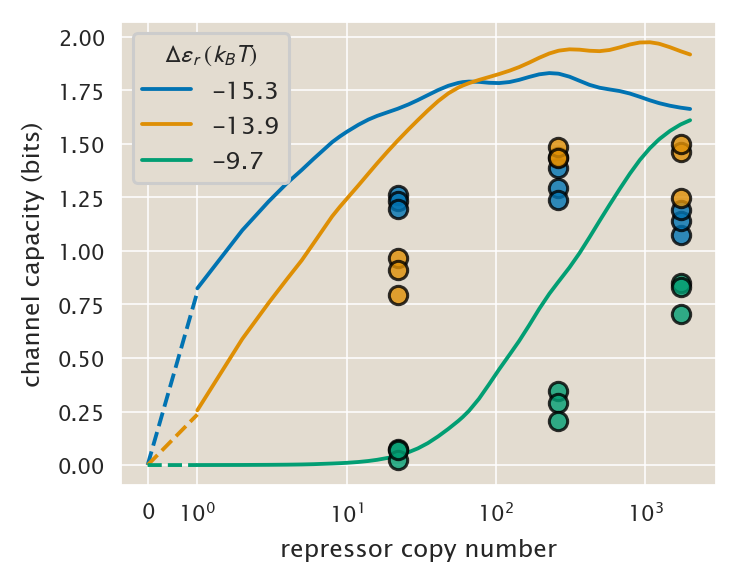

In [15]:
# Group data by operator
df_group = df_cc_protein.groupby("operator")

# Define colors for each operator
operators = df_cc_protein["operator"].unique()
colors = sns.color_palette("colorblind", n_colors=len(operators))
op_col_dict = dict(zip(operators, colors))

# Define threshold for log vs linear section
thresh = 1e0

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.8))
for group, data in df_group:
    # Select x and y data for smoothing
    x = np.log10(data[data.repressor >= thresh].repressor.values)
    y = data[data.repressor >= thresh].channcap.values
    # Define lambda parameter for smoothing
    lam = 0.13
    # Smooth the channel capacity
    channcap_gauss = ccutils.stats.nw_kernel_smooth(x, x, y, lam)
    # Plot Log scale
    ax.plot(
        data[data.repressor >= thresh].repressor,
        channcap_gauss,
        label=op_dict[group],
        color=col_dict[group],
    )

    # Plot linear scale
    ax.plot(
        data[data.repressor <= thresh].repressor,
        data[data.repressor <= thresh].channcap,
        label="",
        color=op_col_dict[group],
        linestyle="--",
    )
    # Plot data from operator
    ax.plot(
        df_cc_exp[df_cc_exp["operator"] == group]["repressors"],
        df_cc_exp[df_cc_exp["operator"] == group]["channcap"],
        lw=0,
        marker="o",
        color=op_col_dict[group],
        label="",
        alpha=0.8,
        markeredgecolor="black",
        markeredgewidth=1,
    )

# Label plot
ax.set_xlabel("repressor copy number")
ax.set_ylabel("channel capacity (bits)")
ax.set_xscale("symlog", linthreshx=thresh, linscalex=0.3)
ax.legend(loc="upper left", title=r"$\Delta\epsilon_r \; (k_BT)$")

# Save figure
plt.savefig(
    f"{figdir}theory_vs_data_channcap_protein_multiprom.pdf",
    bbox_inches="tight",
)
plt.savefig(
    f"{figdir}theory_vs_data_channcap_protein_multiprom.svg",
    bbox_inches="tight",
)

Since for some reason we are still not able to explain our theoretical model results in systematically narrower distributions, the resulting channel capacity is higher than the channel capacity inferred from the data. 

Let's look at this more systematically. Let's plot the theory vs data to see if there is a systematic trend for all data.

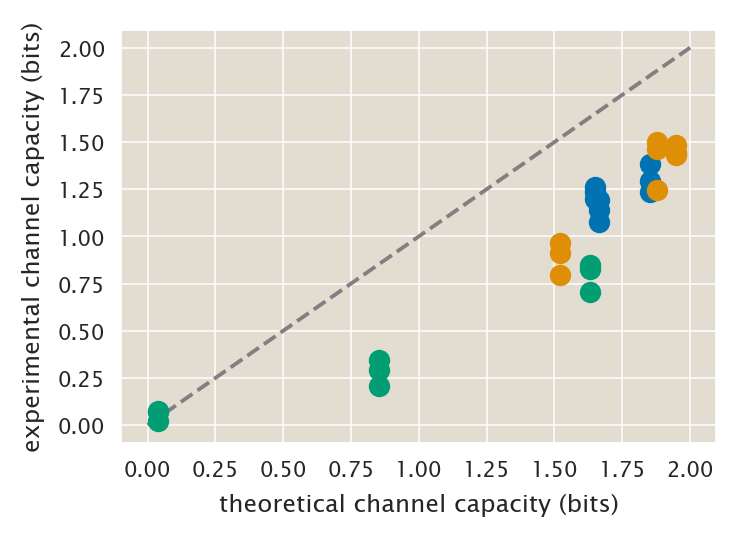

In [16]:
# Group experimental channel capacity by operator and repressor
df_group = df_cc_exp.groupby(["operator", "repressors"])

# Define colors for each operator
operators = df_cc_protein["operator"].unique()
colors = sns.color_palette("colorblind", n_colors=len(operators))
op_col_dict = dict(zip(operators, colors))

# Initalize figure
fig, ax = plt.subplots(1, 1)

# Plot the identity line
ax.plot([0, 2], [0, 2], linestyle='--', color='gray')

# Loop through each of these groups
for group, df_exp in df_group:
    # Extract theoretical prediction
    df_thry = df_cc_protein[
        (df_cc_protein.operator == group[0]) &
        (df_cc_protein.repressor == group[1])
    ]
    # Plot theory vs data
    ax.plot([df_thry.channcap.values] * len(df_exp), df_exp.channcap,
            lw=0, marker='o', color=op_col_dict[group[0]])

ax.set_xlabel('theoretical channel capacity (bits)')
ax.set_ylabel('experimental channel capacity (bits)');

Other than the first point where there is no information about the input in the input-output function, the other points show a systematic shift. We can gain intuition for why this constant shift happens from the approximate analytical form of the channel capacity under the so-called small noise approximation. Under this small noise approximation the channel capacity takes the form
$$
I = \log_2\left( {Z \over \sqrt{2 \pi e}} \right),
\tag{4}
$$
where $Z$ is the normalization constant of the optimal input distribution. This Z takes the form
$$
Z \equiv \int_{\left\langle p(c = 0)\right\rangle}^{\left\langle p(\rightarrow \infty)\right\rangle} 
{1 \over \sigma_p(\left\langle p \right\rangle)}
d\left\langle p \right\rangle,
\tag{5}
$$
where $\sigma_p(\left\langle p \right\rangle)$ is the standard deviation of the protein distribution as a function of the mean of the distribution. We note that this is not the input distribution of inducer concentrations $c$, but since there is a deterministic relationship between the inducer concentration and the mean output, in the small noise approximation we use the fact that
$$
P(c) dc = P(\left\langle p \right\rangle) d\left\langle p \right\rangle.
\tag{6}
$$

From this we can see what the nature of the systematic deviation in the channel capacity should be. Our model predicts a standard deviation that is systematically a factor of two smaller than the experimental data. That means that
$$
\sigma_p^{\exp} = 2 \sigma_p^{\text{theory}}.
\tag{7}
$$
Therefore in terms of the normalization constant Z we have that
$$
Z^{\exp} = {1\over 2} Z^{\text{theory}}.
\tag{8}
$$
As a consequence the difference in channel capacity is of the form
$$
I^{\exp} = I^{\text{theory}} - \log_2(2).
\tag{9}
$$

The small noise approximation then predicts that our data should be systematically off by a constant of one bit (\log_2(2)). We don't expect the small noise approximation to directly apply to our situation given the level of cell-to-cell variability, nevertheless from this we learn that there should be a single constant value that explains the deviation of the data. To find such value we will perform a "linear regression" with a fixed slope of 1 between the predictions and the data. The intercept will inform us on what this systematic deviation is. Let's first define the function to compute the residuals for this fit

In [34]:
def intercept_resid(b, I_data, I_theory):
    """
    Computes the residuals
    """
    return ((I_data - (I_theory + b))**2).sum()

Now let's use this function with `scipy.optimize.fsolve` to find the intercept.

In [51]:
# Initialize list to save theoretical channel capacity
I_theory = list()
# Loop through columns of dataframe with experimental channel capacity
for index, row in df_cc_exp.iterrows():
    # Extract information
    op = row.operator
    rep = row.repressors
    # Extract theoretical channel capacity
    I_theory.append(
        df_cc_protein[
            (df_cc_protein.repressor == rep) & (df_cc_protein.operator == op)
        ].channcap.values
    )
# Add column to dataframe
df_cc_exp = df_cc_exp.assign(channcap_theory=np.array(I_theory))

# Select data that does not include O3 R22
data = df_cc_exp[~((df_cc_exp.repressors == 22) &
                   (df_cc_exp.operator == 'O3'))]
# Use scipy's fsolve to find intercept
intercept = scipy.optimize.fsolve(
    intercept_resid, 0.5, args=(data.channcap, 
                                data.channcap_theory)
)
print(f'Systematic deviation: {np.round(intercept[0], 2)} bits')

Systematic deviation: -0.56 bits


This tells us that there is a systematic deviation of 0.56 bits. Let's take a look at this prediction by reproducing the theory vs. data plot, correcting the theoretical predictions by this constant amount.

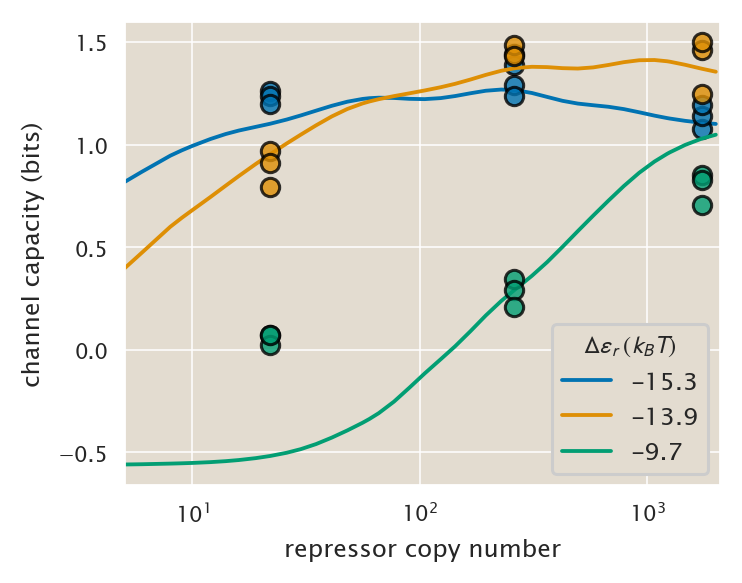

In [57]:
# Group data by operator
df_group = df_cc_protein.groupby("operator")

# Define colors for each operator
operators = df_cc_protein["operator"].unique()
colors = sns.color_palette("colorblind", n_colors=len(operators))
op_col_dict = dict(zip(operators, colors))

# Define threshold for log vs linear section
thresh = 1e0

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.8))
for group, data in df_group:
    # Select x and y data for smoothing
    x = np.log10(data[data.repressor >= thresh].repressor.values)
    y = data[data.repressor >= thresh].channcap.values
    # Define lambda parameter for smoothing
    lam = 0.13
    # Smooth the channel capacity
    channcap_gauss = ccutils.stats.nw_kernel_smooth(x, x, y, lam)
    # Plot Log scale
    ax.plot(
        data[data.repressor >= thresh].repressor,
        channcap_gauss + intercept,
        label=op_dict[group],
        color=col_dict[group],
    )
    # Plot data from operator
    ax.plot(
        df_cc_exp[df_cc_exp["operator"] == group]["repressors"],
        df_cc_exp[df_cc_exp["operator"] == group]["channcap"],
        lw=0,
        marker="o",
        color=op_col_dict[group],
        label="",
        alpha=0.8,
        markeredgecolor="black",
        markeredgewidth=1,
    )

# Fix axis range
ax.set_xlim(left=5)
# Label plot
ax.set_xlabel("repressor copy number")
ax.set_ylabel("channel capacity (bits)")
ax.set_xscale("symlog", linthreshx=thresh, linscalex=0.3)
ax.legend(loc="lower right", title=r"$\Delta\epsilon_r \; (k_BT)$")

Indeed this correction works for all data with channel capacity > 0. There is no way of having negative information, so the correction cannot apply to a datum with 0 channel capacity.

### Looking at the input distributions at channel capacity $P^*(c)$

In order to compute the channel capacity, the Blahut-Arimoto algorithm systematically found a distribution $P^*(c)$ that maximized the mutual information between inputs $c$ and outputs $p$. Since some of these biophysical parameters give channel capacities higher than 1 bit, it is interesting to look at these distributions. Lets plot some of them.

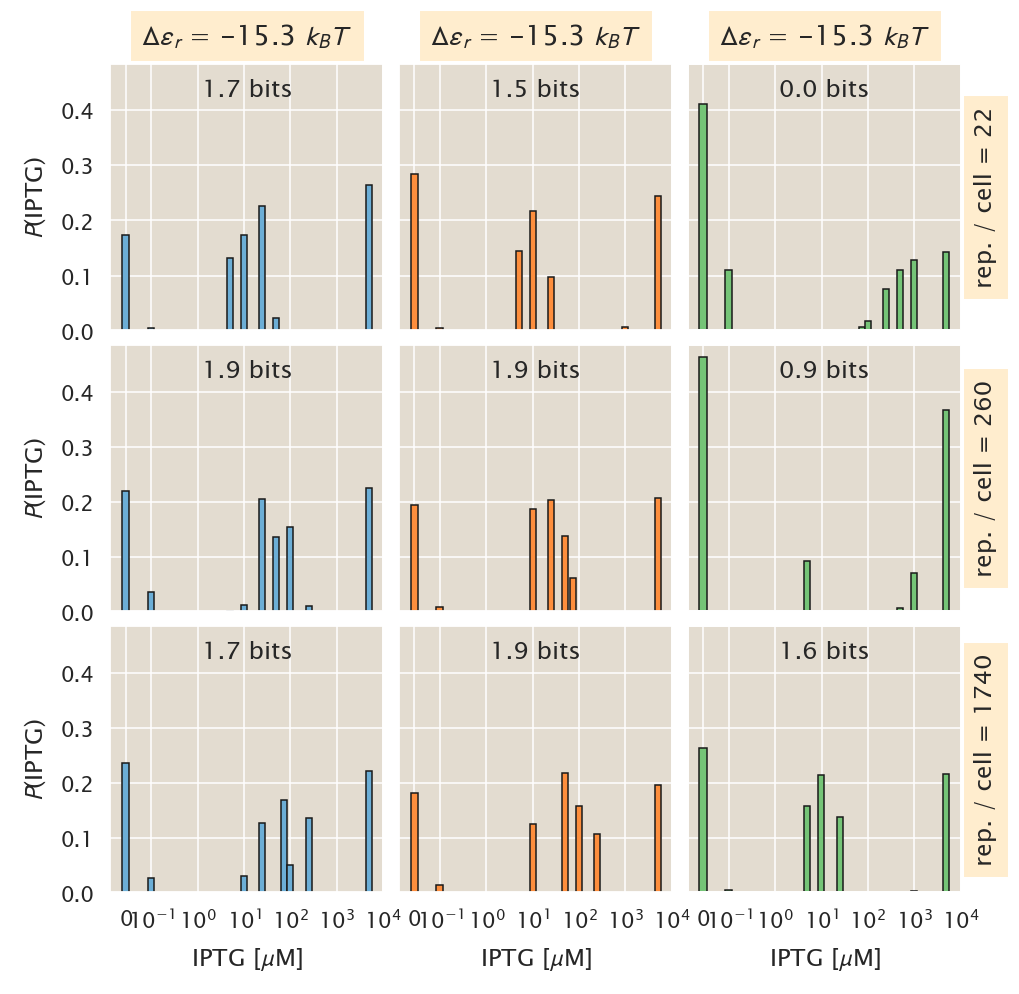

In [17]:
# Extract concentrations
inducer = df_maxEnt_prot.inducer_uM.unique()

# Define operators to be included
operators = ["O1", "O2", "O3"]

# Define repressors to be included
repressors = [22, 260, 1740]

# Define color for operators
# Generate list of colors
col_list = ["Blues_r", "Oranges_r", "Greens_r"]
col_dict = dict(zip(operators, col_list))

# Initialize plot
fig, ax = plt.subplots(
    len(repressors), len(operators), figsize=(5, 5), sharex=True, sharey=True
)

# Loop through operators
for j, op in enumerate(operators):
    # Loop through repressors
    for i, rep in enumerate(repressors):
        # Extract example dist
        dist = df_cc_protein[
            (df_cc_protein.repressor == rep) & (df_cc_protein.operator == op)
        ]["pc"].values[0]
        # Clean weird format of distribution
        dist = dist.replace("\n", "")
        dist = dist.replace("[", "")
        dist = dist.replace("]", "")
        dist = [float(x) for x in dist.split(" ")]
        # Extract channel capacity
        cc = df_cc_protein[
            (df_cc_protein.repressor == rep) & (df_cc_protein.operator == op)
        ]["channcap"]

        # Define colors for plot
        colors = sns.color_palette(col_dict[op], n_colors=1)

        # Define width of bars
        w = 0.13
        width_fn = lambda p, w: 10 ** (np.log10(p) + w / 2.0) - 10 ** (
            np.log10(p) - w / 2.0
        )

        # Plot bars
        # Log scale
        ax[i, j].bar(
            inducer[1:],
            dist[1:],
            width=width_fn(inducer[1:], w),
            color=colors,
            linewidth=0.5,
            edgecolor="k",
        )
        # Linear scale
        ax[i, j].bar(
            inducer[0],
            dist[0],
            width=w / 4.5,
            color=colors,
            linewidth=0.5,
            edgecolor="k",
        )

        # Add text indicating channel capacity
        ax[i, j].text(
            0.5,
            0.9,
            "{:.1f} bits".format(float(cc)),
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax[i, j].transAxes,
            fontsize=8,
        )

        # Add x label to lower plots
        if i == 2:
            ax[i, j].set_xlabel(r"IPTG [$\mu$M]")
        # Add y label to left plots
        if j == 0:
            ax[i, j].set_ylabel(r"$P$(IPTG)")

        # Add operator top of colums
        if i == 0:
            label = r"$\Delta\epsilon_r$ = {:.1f} $k_BT$".format(
                df_maxEnt_prot.binding_energy.unique()[0]
            )
            ax[i, j].set_title(label, bbox=dict(facecolor="#ffedce"))

        # Add repressor copy number to right plots
        if j == 2:
            # Generate twin axis
            axtwin = ax[i, j].twinx()
            # Remove ticks
            axtwin.get_yaxis().set_ticks([])
            # Set label
            axtwin.set_ylabel(
                r"rep. / cell = {:d}".format(rep),
                bbox=dict(facecolor="#ffedce"),
            )
            # Remove residual ticks from the original left axis
            ax[i, j].tick_params(color="w", width=0)

        # Change scale of x axis
        ax[i, j].set_xscale("symlog", linthreshx=0.1, linscalex=0.5)

# Change ylim
# Adjust spacing between plots
plt.subplots_adjust(hspace=0.05, wspace=0.05)

# Save figure
plt.savefig(figdir + "channcap_dist_grid.pdf", bbox_inches="tight")

We can see that there is a non-negligibe mass in in between the low and high concentrations for systemos with $\gtrapprox$ 1 bit of information. This is expected exactly for systems that can process more than one bit of information since the choices are not longer binary.

## Extending the range or repressor copy numbers.

In order to explore the behavior of the curves we now extend the inference to larger repressor copy number counts. We have computed the constraints and Lagrange multipliers for distributions up to $10^6$ repressors per cell. The script `channcap_protein_multi_prom_rep_range.py` uses these inferences to then compute the corresponding channel capacity prediction for this extended repressor copy number. Lets take a look at the resulting values.

In [18]:
df_cc_protein = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/chann_cap_multi_prom_protein_ext_R.csv"
)

df_cc_protein = df_cc_protein[df_cc_protein.channcap != np.inf]

Let's now plot the results.

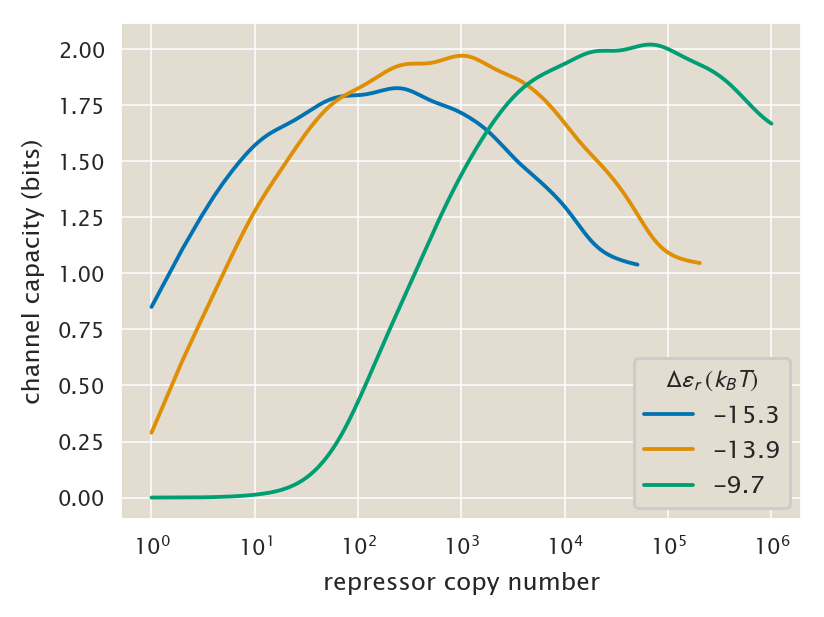

In [19]:
# Group data by operator
df_group = df_cc_protein.groupby('operator')

# Define colors for each operator
operators = df_cc_protein['operator'].unique()
colors = sns.color_palette('colorblind', n_colors=len(operators))
op_col_dict = dict(zip(operators, colors))

# Define threshold for log vs linear section
thresh = 1E0

fig, ax = plt.subplots(1, 1, figsize=(4,3))
for group, data in df_group:
    # Select x and y data for smoothing
    x = np.log10(data[data.repressor >= thresh].repressor.values)
    y = data[data.repressor >= thresh].channcap.values
    # Define lambda parameter for smoothing
    lam = 0.16
    # Smooth the channel capacity
    channcap_gauss = ccutils.stats.nw_kernel_smooth(x, x, y,lam)
    # Plot protein channel capacity
    # Log scale
    ax.plot(data[data.repressor >= thresh].repressor,
               channcap_gauss, 
               label=op_dict[group], color=op_col_dict[group])
    
# Label plot
ax.set_xlabel('repressor copy number')
ax.set_ylabel('channel capacity (bits)')
ax.set_xscale('log')
ax.legend(loc='lower right', title=r'$\Delta\epsilon_r \; (k_BT)$')
plt.savefig(figdir +  'chann_cap_ext_R.pdf', bbox_inches='tight')

## Extending the range of inducer concentrations.

Just as with the extended repressor range, we also performed inference on the maximum entropy distributions for a finer grid of inducer concentrations. The script `channcap_protein_multi_prom_iptg_range.py` takes these distributions and infers the corresponding channel capacity. This with the objective to explore the limitations of using only 12 different experimental inducer concentrations.

In [20]:
# Read maximum entropy distributions
df_maxEnt_prot = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/" + 
    "MaxEnt_Lagrange_mult_protein_IPTG_range.csv"
)

# Read channel capacity concentrations
df_cc_protein = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/" + 
    "chann_cap_multi_prom_protein_IPTG_range.csv"
)

Let's now look at the input distributions at channel capacity with this finer grid of inducer concentrations.

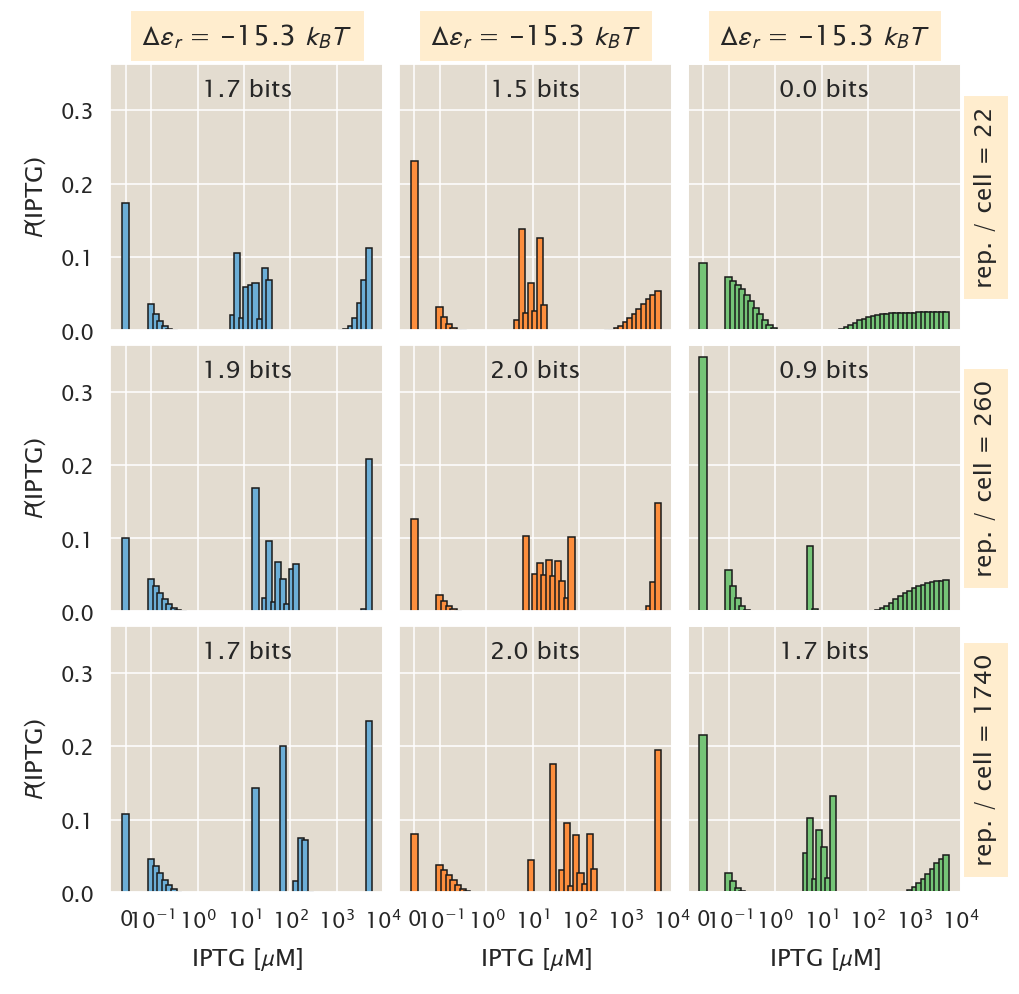

In [21]:
# Extract concentrations
inducer = df_maxEnt_prot.inducer_uM.unique()

# Define operators to be included
operators = ["O1", "O2", "O3"]

# Define repressors to be included
repressors = [22, 260, 1740]

# Define color for operators
# Generate list of colors
col_list = ["Blues_r", "Oranges_r", "Greens_r"]
col_dict = dict(zip(operators, col_list))

# Initialize plot
fig, ax = plt.subplots(
    len(repressors), len(operators), figsize=(5, 5), sharex=True, sharey=True
)

# Loop through operators
for j, op in enumerate(operators):
    # Loop through repressors
    for i, rep in enumerate(repressors):
        # Extract example dist
        dist = df_cc_protein[
            (df_cc_protein.repressor == rep) & (df_cc_protein.operator == op)
        ]["pc"].values[0]
        # Clean weird format of distribution
        dist = dist.replace("\n", "")
        dist = dist.replace("[", "")
        dist = dist.replace("]", "")
        dist = [float(x) for x in dist.split(" ") if x != ""]
        # Extract channel capacity
        cc = df_cc_protein[
            (df_cc_protein.repressor == rep) & (df_cc_protein.operator == op)
        ]["channcap"]

        # Define colors for plot
        colors = sns.color_palette(col_dict[op], n_colors=1)

        # Define width of bars
        w = 0.13
        width_fn = lambda p, w: 10 ** (np.log10(p) + w / 2.0) - 10 ** (
            np.log10(p) - w / 2.0
        )

        # Plot bars
        # Log scale
        ax[i, j].bar(
            inducer[1:],
            dist[1:],
            width=width_fn(inducer[1:], w),
            color=colors,
            linewidth=0.5,
            edgecolor="k",
        )
        # Linear scale
        ax[i, j].bar(
            inducer[0],
            dist[0],
            width=w / 4.5,
            color=colors,
            linewidth=0.5,
            edgecolor="k",
        )

        # Add text indicating channel capacity
        ax[i, j].text(
            0.5,
            0.9,
            "{:.1f} bits".format(float(cc)),
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax[i, j].transAxes,
            fontsize=8,
        )

        # Add x label to lower plots
        if i == 2:
            ax[i, j].set_xlabel(r"IPTG [$\mu$M]")
        # Add y label to left plots
        if j == 0:
            ax[i, j].set_ylabel(r"$P$(IPTG)")

        # Add operator top of colums
        if i == 0:
            label = r"$\Delta\epsilon_r$ = {:.1f} $k_BT$".format(
                df_maxEnt_prot.binding_energy.unique()[0]
            )
            ax[i, j].set_title(label, bbox=dict(facecolor="#ffedce"))

        # Add repressor copy number to right plots
        if j == 2:
            # Generate twin axis
            axtwin = ax[i, j].twinx()
            # Remove ticks
            axtwin.get_yaxis().set_ticks([])
            # Set label
            axtwin.set_ylabel(
                r"rep. / cell = {:d}".format(rep),
                bbox=dict(facecolor="#ffedce"),
            )
            # Remove residual ticks from the original left axis
            ax[i, j].tick_params(color="w", width=0)

        # Change scale of x axis
        ax[i, j].set_xscale("symlog", linthreshx=0.1, linscalex=0.5)

# Change ylim
# Adjust spacing between plots
plt.subplots_adjust(hspace=0.05, wspace=0.05)

# Save figure
plt.savefig(figdir + "channcap_dist_fine_grid.pdf", bbox_inches="tight")

## Computing the channel capacity for a single-promoter at steady state.

In order to compare the effect that the variability in gene copy number has over the invormation processing capacity let's compute the channel capacity for the case where the moments were computed by setting the dynamical equations to steady state and solving for the moments. We have already shown that this model underestimates the noise in gene expression, nevertheless it it insteresting to see what effect this will have on the information processing capacity.

We begin again by reading the Lagrange multipliers that define the protein MaxEnt distributions.

In [22]:
df_cc_single = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/chann_cap_single_prom_protein.csv"
)

# Drop infinities
df_cc_single = df_cc_single[df_cc_single.channcap != np.inf]
df_cc_single.head()

,operator,binding_enery,repressor,channcap,pc
0,O1,-15.3,0.0,0.000000,[0.08333333 0.08333333 0.08333333 0.08333333 0...
1,O1,-15.3,1.0,1.070472,[4.06531421e-01 4.67437940e-03 3.20256759e-02 ...
2,O1,-15.3,2.0,1.319829,[3.38136586e-01 1.30224733e-02 3.38607405e-02 ...
3,O1,-15.3,3.0,1.430546,[3.08349468e-01 1.14517816e-02 5.53302087e-02 ...
4,O1,-15.3,4.0,1.504046,[2.87590153e-01 1.02945379e-02 7.22086878e-02 ...


Let's look at the comparison between the single- and the multi-promoter model channel capacity.

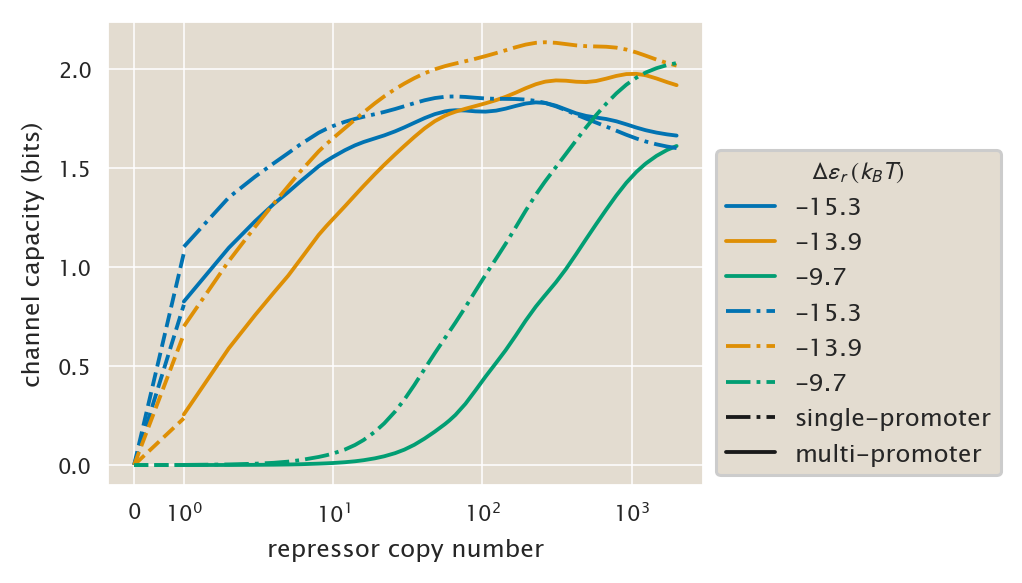

In [23]:
# Read channel capacity of multi promoter model
df_cc_protein = pd.read_csv(
    f"{homedir}/data/csv_maxEnt_dist/chann_cap_multi_prom_protein.csv"
)
# Drop infinities
df_cc_protein = df_cc_protein[df_cc_protein.channcap != np.inf]

# Group data by operator
df_group = df_cc_protein.groupby("operator")

# Define colors for each operator
operators = df_cc_protein["operator"].unique()
colors = sns.color_palette("colorblind", n_colors=len(operators))
op_col_dict = dict(zip(operators, colors))

# Define threshold for log vs linear section
thresh = 1e0

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.8))

# Plot multi-promoter data
for group, data in df_group:
    # Select x and y data for smoothing
    x = np.log10(data[data.repressor >= thresh].repressor.values)
    y = data[data.repressor >= thresh].channcap.values
    # Define lambda parameter for smoothing
    lam = 0.13
    # Smooth the channel capacity
    channcap_gauss = ccutils.stats.nw_kernel_smooth(x, x, y, lam)
    # Plot Log scale
    ax.plot(
        data[data.repressor >= thresh].repressor,
        channcap_gauss,
        label=op_dict[group],
        color=op_col_dict[group],
    )

    # Plot linear scale
    ax.plot(
        data[data.repressor <= thresh].repressor,
        data[data.repressor <= thresh].channcap,
        label="",
        color=op_col_dict[group],
        linestyle="--",
    )

#  # Group data by operator
df_group = df_cc_single.groupby("operator")

# Plot single-promoter
for group, data in df_group:
    # Select x and y data for smoothing
    x = np.log10(data[data.repressor >= thresh].repressor.values)
    y = data[data.repressor >= thresh].channcap.values
    # Define lambda parameter for smoothing
    lam = 0.15
    # Smooth the channel capacity
    channcap_gauss = ccutils.stats.nw_kernel_smooth(x, x, y, lam)
    # Plot Log scale
    ax.plot(
        data[data.repressor >= thresh].repressor,
        channcap_gauss,
        label=op_dict[group],
        color=op_col_dict[group],
        linestyle="-.",
    )

    # Plot linear scale
    ax.plot(
        data[data.repressor <= thresh].repressor,
        data[data.repressor <= thresh].channcap,
        label="",
        color=op_col_dict[group],
        linestyle="--",
    )

# Add artificial plots to add legend
ax.plot([], [], linestyle="-.", color="k", label="single-promoter")
ax.plot([], [], linestyle="-", color="k", label="multi-promoter")

# Increase y limit

# Label plot
ax.set_xlabel("repressor copy number")
ax.set_ylabel("channel capacity (bits)")
ax.set_xscale("symlog", linthreshx=thresh, linscalex=0.3)
ax.legend(
    loc="upper left",
    title=r"$\Delta\epsilon_r \; (k_BT)$",
    bbox_to_anchor=(1, 0.75),
)


# Save figure
plt.savefig(figdir + "channcap_single_vs_multi.pdf", bbox_inches="tight")

We can see that as expected, given that the single-promoter model underestimates the noise in gene expression even more than our multi-promoter model, it systematically predicts  a much higher channel capacity for all constructs.